In [1]:
import country_converter as coco
from owid.catalog import Dataset
from etl.data_helpers import geo
import matplotlib.pyplot as plt
from etl.paths import DATA_DIR
import seaborn as sns
import pandas as pd
import numpy as np
import re
from mpl_chord_diagram import chord_diagram


ds = Dataset(DATA_DIR
            / "garden"
            / "tourism"
            / "2023-05-05"
            / "unwto")

print(ds.table_names)

['unwto']


In [2]:
df = pd.DataFrame(ds['unwto'])
df.set_index(['country', 'year'], inplace = True)
assert len(df.index.levels) == 2 and df.index.is_unique, "Index is not well constructed"

In [3]:
import yaml
# Load the YAML data file
with open("/Users/veronikasamborska/etl/etl/steps/data/garden/tourism/2023-05-05/unwto.meta.yml", 'r') as file:
    data = yaml.safe_load(file)

In [4]:
info_list = []
for col in df.columns:
    df_emp_drop_na = pd.DataFrame(df[col].dropna())
    df_emp_drop_na.reset_index(inplace=True)
    df_emp_drop_na = df_emp_drop_na[df_emp_drop_na['year'] == 2021]
    unique_countries = np.unique(df_emp_drop_na['country'])
    num_unique_countries = len(unique_countries)
    title = data['tables']['unwto']['variables'][col]['title']
    
    # Add the information to the list
    info_list.append(f"Column '{title}': {num_unique_countries} unique countries for 2021")

# Save the information to a text file
with open('/Users/veronikasamborska/unwto_scope.txt', 'w') as file:
    file.write('\n'.join(info_list))

    

In [5]:
import pandas as pd

info_list = []
for col in df.columns:
    df_emp_drop_na = pd.DataFrame(df[col].dropna())
    df_emp_drop_na.reset_index(inplace=True)
    df_emp_drop_na = df_emp_drop_na[(df_emp_drop_na['year'] >= 2018) & (df_emp_drop_na['year'] <= 2021)]
    unique_countries = df_emp_drop_na['country'].unique()
    num_unique_countries = len(unique_countries)
    title = data['tables']['unwto']['variables'][col]['title']
    
    # Add the information to the list
    info_list.append({'Column': title, 'Num Unique Countries': num_unique_countries})

# Create a DataFrame from the info_list
info_df = pd.DataFrame(info_list)

# Save the DataFrame to a CSV file
info_df.to_csv('/Users/veronikasamborska/unwto_scope.csv', index=False)

In [6]:
countries_file = pd.read_csv('/Users/veronikasamborska/etl/etl/steps/data/garden/tourism/2023-05-05/countries_regions.csv')

In [7]:
continents = ['World', 'Africa', 'Asia', 'Europe', 'South America',\
              'North America', 'Oceania', 'European Union (27)']

df.reset_index(inplace = True)

In [8]:
len(np.unique(df['country']))

228

In [9]:
continent_list = []
for country in df['country']:
    if country not in ['Africa (UNWTO)', 'Americas (UNWTO)', 'East Asia and the Pacific (UNWTO)', 'Europe (UNWTO)', 'Middle East (UNWTO)', 'Not classified (UNWTO)', 'South Asia (UNWTO)']:
        # Find the corresponding code in df2
        code = countries_file.loc[countries_file['name'] == country, 'code'].values
        if len(code) > 0:
            code = code[0]
            found_continent = False
            for continent in ['Africa','Asia', 'Europe', 'South America', 'North America', 'Oceania']:
                continent_members = countries_file.loc[countries_file['name'] == continent, 'members'].values[0]
                if code in continent_members:
                    continent_list.append(continent)
                    found_continent = True
                    break
            if not found_continent:
                print(1)
                continent_list.append("Unknown")
        else:
            print(1)
            continent_list.append("Unknown")
    else:
        continent_list.append(country)

In [10]:
df['continent'] = continent_list

group_by_reg = ['in_to_re_af', 'in_to_re_am',
'in_to_re_ea_as_an_th_pa', 'in_to_re_eu', 'in_to_re_mi_ea',
'in_to_re_ot_no_cl', 'in_to_re_so_as']

# Filter the dataframe to include only countries and years for which both columns have non-null values
filtered_df = df.dropna(subset=group_by_reg, how='any')

# Group the filtered dataframe by continent and calculate the sum for each year for the specified columns
continent_year_sums = filtered_df.groupby(['continent', 'year'])[group_by_reg].sum()
new_column_names = ['Africa', 'Americas', 'East Asia, South Asia, and the Pacific', 'Europe', 'Middle East', 'Not Classified', 'South Asia']
continent_year_sums.rename(columns=dict(zip(group_by_reg, new_column_names)), inplace=True)
continent_year_sums['Asia and Oceania'] = continent_year_sums[['East Asia, South Asia, and the Pacific', 'Middle East', 'South Asia']].sum(axis=1)
continent_year_sums_adj = continent_year_sums[['Africa', 'Americas','Europe','Not Classified','Asia and Oceania']]
continent_year_sums_adj.reset_index(inplace = True)
# Replace continent values to combine them
continent_year_sums_adj.loc[continent_year_sums_adj['continent'].isin(['North America', 'South America']), 'continent'] = 'Americas'
continent_year_sums_adj.loc[continent_year_sums_adj['continent'].isin(['Oceania', 'Asia']), 'continent'] = 'Asia and Oceania'
# Group the filtered dataframe by continent and calculate the sum for each year for the specified columns
continent_year_sums_adj = continent_year_sums_adj.groupby(['continent', 'year']).sum()
continent_year_sums_adj = continent_year_sums_adj.reset_index()


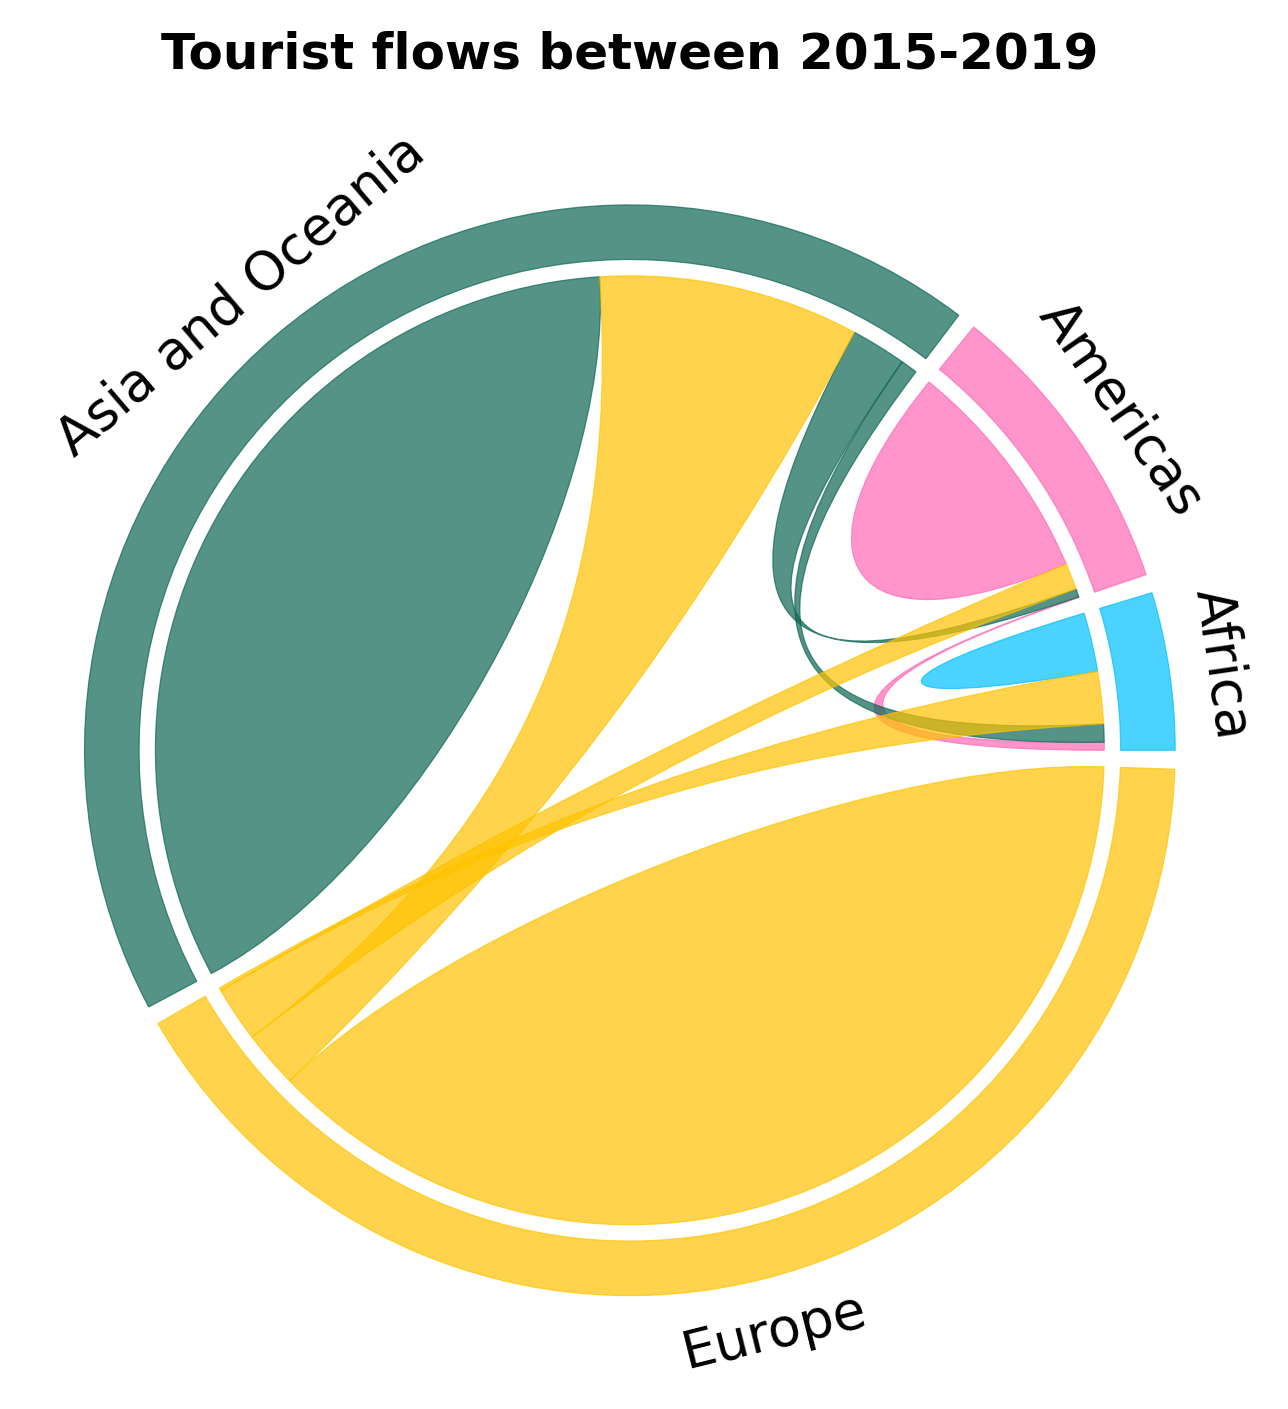

In [11]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_chord_diagram import chord_diagram
import matplotlib.animation as animation
from matplotlib.animation import FFMpegWriter

# Calculate the overall maximum value in the dataframe
overall_max = continent_year_sums_adj.iloc[:, 1:].max().max()

def update_chord_diagram(frame):
    year_range = frame
    # Filter the data for the specified year range
    filtered_data = continent_year_sums_adj[(continent_year_sums_adj['year'] >= year_range[0]) & (continent_year_sums_adj['year'] <= year_range[1])]
    filtered_data = filtered_data.groupby('continent').sum().reset_index()

    # Exclude the 'Other' column
    exclude_other = filtered_data[['continent', 'Africa', 'Americas', 'Asia and Oceania', 'Europe']]
    
    # Get the labels for the nodes
    labels = exclude_other.columns[1:].tolist()
    
    # Get the matrix for the chord diagram
    matrix = exclude_other.iloc[:, 1:].values.tolist()
    
    # Calculate the maximum value for this year range's data
    max_value = exclude_other.iloc[:, 1:].max().max()
    
    # Set the color mapping limit based on the overall maximum value
    color_limit = max(overall_max, max_value)
    colors = ['#00BFFF', '#FF69B4', '#0E6655', '#FFC300']

    # Create the chord diagram
    fig.clear()
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_title('Tourist flows between ' + str(year_range[0]) + '-' + str(year_range[1]), pad=20, fontweight='bold')  # Add padding and make title bold
    chord_diagram(matrix, names=labels, colors=colors, ax=ax, color_limit=color_limit)
    
    # Check if this is the last frame
    if frame == year_ranges[-1]:
        anim.event_source.stop()

# Set the range of years
start_year = 1995
end_year = 2021

# Calculate the number of 5-year ranges
num_ranges = (end_year - start_year + 1) // 5

# Create the list of year ranges
year_ranges = [(start_year + 5*i, start_year + 5*(i+1) - 1) for i in range(num_ranges)]

# Create the figure
fig = plt.figure(dpi=300)

# Create the animation
anim = FuncAnimation(fig, update_chord_diagram, frames=year_ranges, interval=500, repeat=False)

# Save the animation as an mp4 file
writer = FFMpegWriter(fps=0.3, bitrate=1800)  # Adjust the bitrate as needed
anim.save('/Users/veronikasamborska/Desktop/chord_diagram_animation.mp4', writer=writer)

# Display the animation
plt.show()

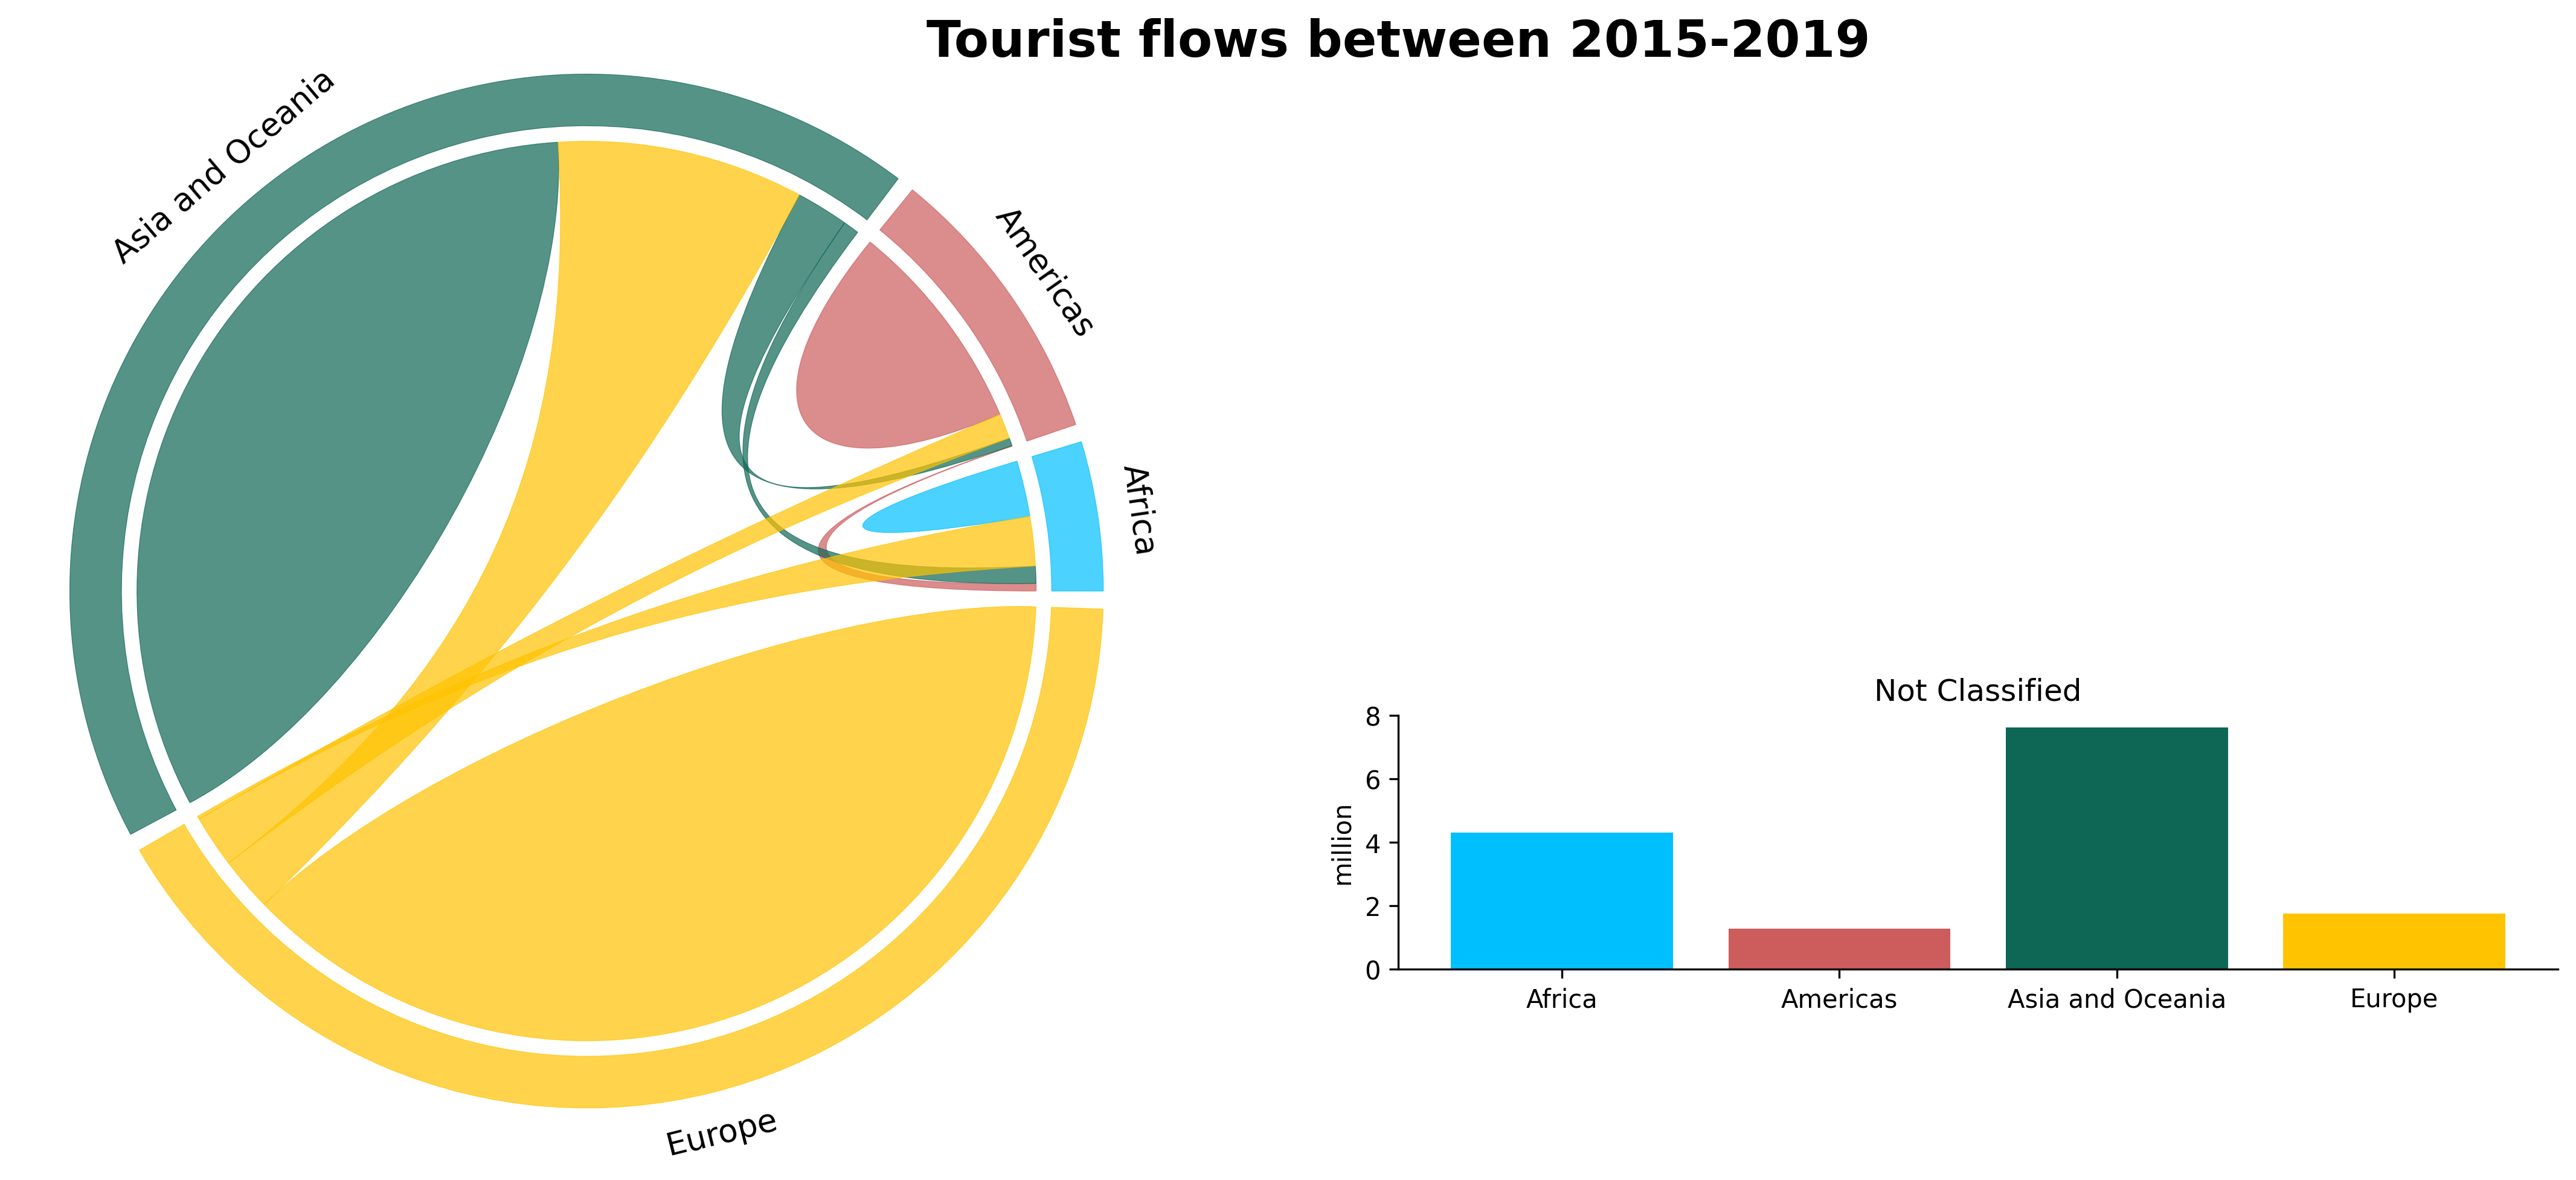

In [1092]:

def update_chord_diagram(frame):
    year_range = frame
    # Filter the data for the specified year range
    filtered_data = continent_year_sums_adj[(continent_year_sums_adj['year'] >= year_range[0]) & (continent_year_sums_adj['year'] <= year_range[1])]
    filtered_data = filtered_data.groupby('continent').sum().reset_index()

    # Exclude the 'Other' and 'Not Classified' columns
    exclude_other = filtered_data[['continent', 'Africa', 'Americas', 'Asia and Oceania', 'Europe']]
    not_classified = filtered_data[['continent', 'Not Classified']].copy()
    not_classified['Not Classified'] = not_classified['Not Classified'] / 1e7
    # Get the labels for the nodes
    labels = exclude_other.columns[1:].tolist()
    
    # Get the matrix for the chord diagram
    matrix = exclude_other.iloc[:, 1:].values.tolist()
    
    # Calculate the maximum value for this year range's data
    max_value = exclude_other.iloc[:, 1:].max().max()
    
    # Set the color mapping limit based on the overall maximum value
    color_limit = max(overall_max, max_value)
    colors = ['#00BFFF', '#CD5C5C', '#0E6655', '#FFC300', '#FF1493']  # Including a bright pink color
    
    # Create the chord diagram
    fig.clear()
    fig.suptitle('Tourist flows between ' + str(year_range[0]) + '-' + str(year_range[1]), fontsize=20, fontweight='bold', y=0.95)

    ax1 = fig.add_subplot(gs[0], aspect='equal')
    chord_diagram(matrix, names=labels, colors=colors[:-1], ax=ax1, color_limit=color_limit)


    ax2 = fig.add_subplot(gs[1])
    ax2.set_title('Not Classified')
    ax2.bar(not_classified['continent'], not_classified['Not Classified'], color=colors[:-1])
    ax2.set_ylabel('million')
    ax2.set_ylim(0,8)

    # Remove spines
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Calculate the size of the first subplot based on the total number of arrivals
    total_arrivals = exclude_other.iloc[:, 1:].sum().sum()
    ax1_size = 0.5+(total_arrivals/1e10)  # Adjust the scaling factor (0.5) as needed
    # Adjust the size of the subplots
    ax1.set_position([-0.18, 0.05, 0.8, ax1_size])
    ax2.set_position([0.5, 0.2, 0.4, 0.2])
    
    # Check if this is the last frame
    if frame == year_ranges[-1]:
        anim.event_source.stop()
start_year = 1995
end_year = 2021

# Calculate the number of 5-year ranges
num_ranges = (end_year - start_year + 1) // 5

# Create the figure with adjusted subplot heights
fig = plt.figure(dpi=300, figsize=(16, 7))
gs = fig.add_gridspec(2, 1)

# Create the first subplot for the chord diagram
ax1 = fig.add_subplot(gs[0], aspect='equal')

# Create the second subplot for the bar plot
ax2 = fig.add_subplot(gs[1])
ax2.set_title('Not Classified')

# Create the animation
anim = FuncAnimation(fig, update_chord_diagram, frames=year_ranges, interval=500, repeat=False)

# Save the animation as an mp4 file
writer = FFMpegWriter(fps=0.3, bitrate=1800)  # Adjust the bitrate as needed
anim.save('/Users/veronikasamborska/Desktop/chord_diagram_animation.mp4', writer=writer)

# Display the animation
plt.show()

In [1044]:
filtered_data = continent_year_sums_adj[(continent_year_sums_adj['year'] >= 2000) & (continent_year_sums_adj['year'] <= 2005)]
filtered_data = filtered_data.groupby('continent').sum().reset_index()

# Exclude the 'Other' and 'Not Classified' columns
exclude_other = filtered_data[['continent', 'Africa', 'Americas', 'Asia and Oceania', 'Europe']]
not_classified = filtered_data[['continent', 'Not Classified']].copy()
not_classified['Not Classified'] = not_classified['Not Classified'] / 1e7

In [1045]:
not_classified

continent  Not Classified
0            Africa        1.589000
1          Americas        0.011966
2  Asia and Oceania        1.678700
3            Europe        0.645900

In [ ]:
def compare_world_bank():
    link_to_world_bank = 'https://api.worldbank.org/v2/en/indicator/ST.INT.ARVL?downloadformat=excel'
    excel_object = pd.ExcelFile(link_to_world_bank)
    wb = pd.read_excel(excel_object, sheet_name = 'Data', header=3)

    # Drop additional columns
    columns_to_drop = ['Indicator Code', 'Indicator Name', 'Country Code']
    wb = wb.drop(columns=[col for col in columns_to_drop if col in df.columns])

    # Rename the 'Basic data and indicators' column to 'country'
    wb = wb.rename(columns={'Country Name': 'country'})

    # Create the list of years to include in the output DataFrame
    years = [str(year) for year in range(1995, 2022)]

    non_year_cols = ['country']

    # Melt the DataFrame to a long format
    df_wb = wb.melt(id_vars=non_year_cols, value_vars=years, var_name='year')
    df_wb["year"] = df_wb["year"].astype(int)

    df_wb.set_index(['country', 'year'], inplace=True)

    assert df_wb.index.is_unique, f"Index is not unique." # Added assert statement to check index is unique

    unwto= df.loc['Poland', (slice(None)), :]['Arrivals (total)']
    wb = df_wb.loc['Poland', (slice(None)), :]['value']

    unwto_tor= df.loc['Poland', (slice(None)), :]['Arrivals (tourists)']

    plt.plot(unwto, color = 'black', alpha = 1, label = 'UNWTO Poland Total')
    plt.plot(wb/1000, color = 'pink', alpha = 1,  linestyle = '--', label = 'WB Poland')
    plt.plot(unwto_tor, color = 'green', alpha = 1, label = 'UNWTO Poland Tourists only')

    sns.despine()
    plt.xlabel('Year')
    plt.legend()

In [ ]:
def calculate_median_perc_change(df):
    """
    Calculates the median percentage change between consecutive years for each column in a DataFrame.
    Returns a new DataFrame with the median percentage change for each column and each country.
    """
    df_perc_median = []
    for col in df.columns:
        # Calculate the percentage change between consecutive years for each country
        df_changes = df.groupby(level='country')[col].pct_change(periods=2)
        # Group the percentage changes by country and calculate the median
        df_perc_median.append(df_changes.groupby(level='country').median())
    # Create a new DataFrame with the median percentage change for each column and each country
    df_perc_median = pd.DataFrame(df_perc_median)
    df_perc_median = df_perc_median.T
    return df_perc_median

In [ ]:
# Plotting functions 

def plot_subplots(df, n_cols=4, fig_size=(10, 3)):
    """
    Plot each column of a DataFrame as a subplot.

    Parameters:
    df (pandas.DataFrame): The DataFrame to plot.
    n_cols (int): The number of columns to use for the subplots.
    fig_size (tuple): The size of the figure in inches, in the format (width, height).

    Returns:
    None.
    """
    # determine the number of rows and columns needed based on the number of columns in the DataFrame
    num_cols = len(df.columns)
    num_rows = (num_cols + n_cols - 1) // n_cols

    # set the figure size and create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=n_cols, figsize=(fig_size[0], fig_size[1]*num_rows))

    # iterate over the columns and plot each one
    for i, col in enumerate(df.columns):
        row = i // n_cols
        col_ = i % n_cols
        df[col].plot(ax=axes[row, col_], legend=False)
        axes[row, col_].set_title(col)

    # adjust the spacing between subplots and display the figure
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_top_countries(top_countries, year, title):
    plt.figure(figsize=(20, 6))
    plt.scatter(np.arange(len(top_countries.values)),top_countries.values)
    countries = top_countries.index.get_level_values('country')
    plt.xticks(np.arange(len(top_countries.values)), countries, rotation = 90)
    plt.xlabel('Country')
    plt.ylabel(title)
    plt.title(f'{year}')
    plt.show()


In [ ]:
total_inc = tour_arrivals['in_to_ar_ov_vi_to'].add(tour_arrivals['in_to_ar_sa_da_vi_ex'], fill_value=0)
total_inc.sum(skipna=True)

percentage_df= {}
for country in tour_arrivals.index.get_level_values('country').unique():
    # Calculate total arrivals for each year
    total_arrivals = tour_arrivals.loc[(country, slice(None)), 'in_to_ar_to_ar']
    # Calculate total incoming tourism for each year
    total_inc_tourism = total_inc.loc[(country, slice(None))]
    # Calculate the percentage change between consecutive years
    perc_diff = ((total_inc_tourism-total_arrivals) / total_arrivals) * 100
    # Save the percentage change in a dictionary
    percentage_df[country]  = np.max(abs(perc_diff))
# Convert the dictionary to a DataFrame

df = pd.DataFrame.from_dict(percentage_df, orient='index', columns=['percentage'])


In [ ]:
df_drop = df.dropna()
top_countries = df_drop.sort_values(ascending = True, by = 'percentage').tail(40)


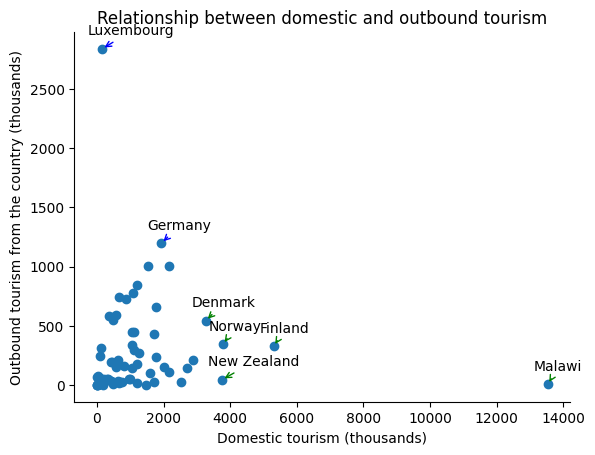

In [ ]:
df_perc_median_dom = calculate_median_perc_change(domestic_tourism)
df_perc_median_out = calculate_median_perc_change(outbound)


x = domestic_tourism.groupby('country').last()[['tour_per_1000']]
y = outbound.groupby('country').last()[['tour_per_1000']]

# Plot the scatter plot
plt.scatter(x,y)

# Add annotations for the top 2 countries with highest arrivals
top_arrivals = x['tour_per_1000'].nlargest(5)
top_deps = y['tour_per_1000'].nlargest(5)

for country in top_arrivals.index:
    plt.annotate(country, (x.loc[country], y.loc[country]), xytext=(-10, 10), textcoords='offset points', fontsize=10, arrowprops=dict(arrowstyle='->', color='green'))


for country in top_deps.index:
    plt.annotate(country, (x.loc[country], y.loc[country]), xytext=(-10, 10), textcoords='offset points', fontsize=10, arrowprops=dict(arrowstyle='->', color='blue'))

# Set the labels and title of the plot
plt.xlabel('Domestic tourism (thousands)')
plt.ylabel('Outbound tourism from the country (thousands)')
plt.title('Relationship between domestic and outbound tourism')
# Draw the equality line
min_val = min(x['tour_per_1000'].min(), y['tour_per_1000'].min())
max_val = max(x['tour_per_1000'].max(), y['tour_per_1000'].max())
# plt.plot([min_val, max_val], [min_val, max_val], 'k--')


sns.despine()

# Show the plot
plt.show()


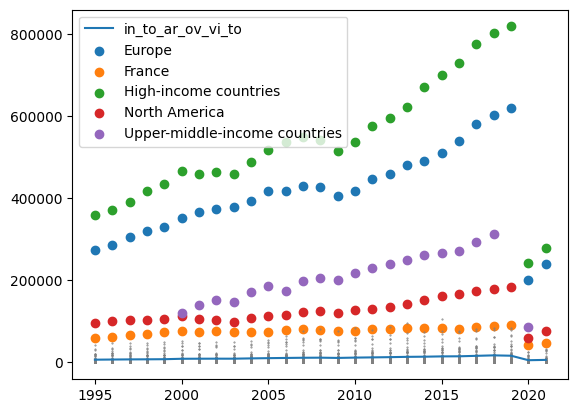

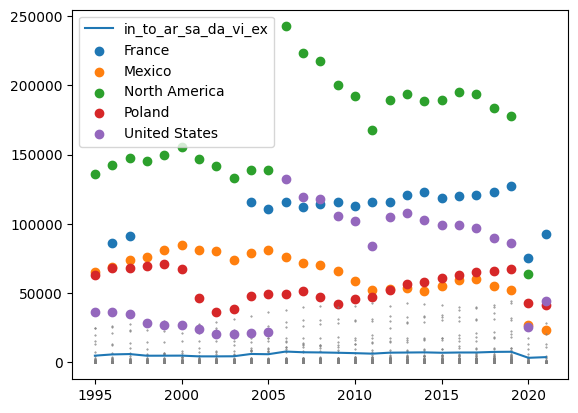

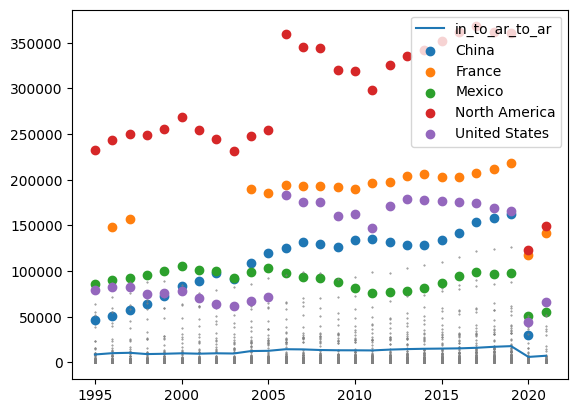

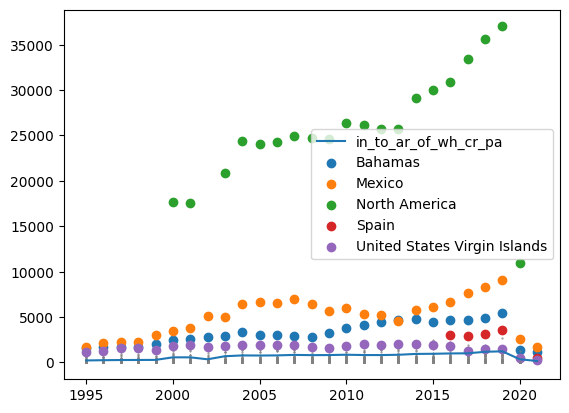

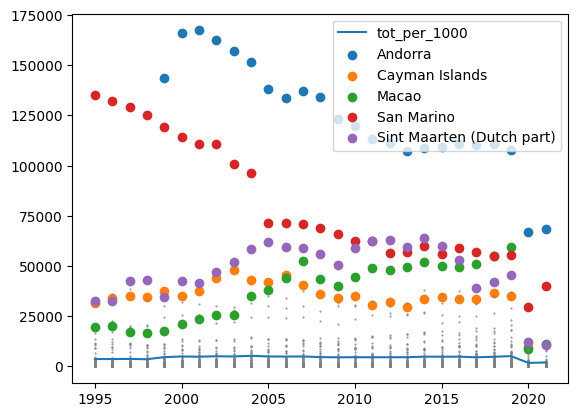

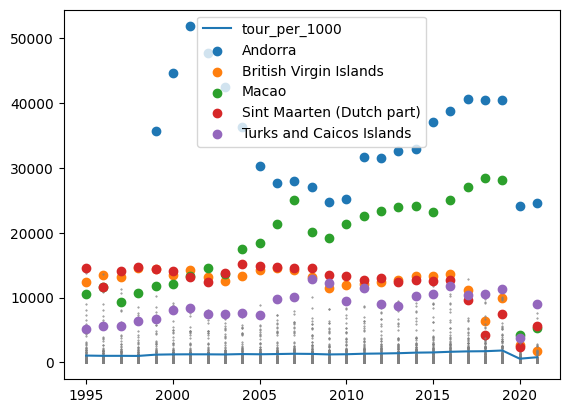

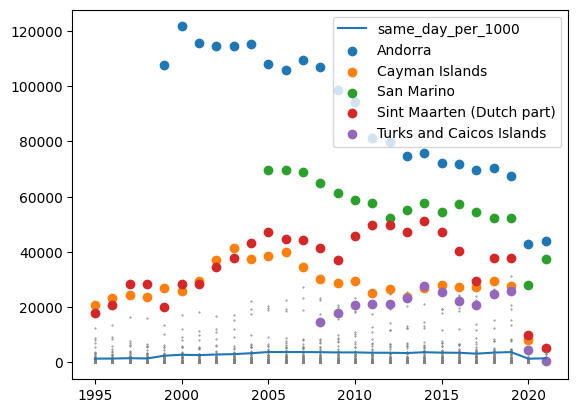

In [ ]:
#dataframes = [tour_arrivals, outbound, domestic_accommodation, domestic_tourism, employment, inbound_accommodation, inbound_exp, purpose, regions, transport_mode, oubound_exp,               tourism_ind, population]

#for df in dataframes[:2]:
for col in tour_arrivals.columns:
    x = tour_arrivals[col].groupby('year').mean()
    plt.figure()
    plt.plot(x, label=col)
    top_countries = tour_arrivals[col].groupby('country').median().nlargest(5).index

    for country in  tour_arrivals[col].index.get_level_values('country').unique():
        x =  tour_arrivals.loc[(country), col]

        if country in top_countries:
            plt.scatter(x.index,x, label = country)
        else:
            plt.scatter(x.index,x, color = 'grey', s = 0.2)
    

    plt.legend()

In [ ]:
names_dictionary

Original                         New
0            in_to_ar_ov_vi_to           in_to_ar_ov_vi_to
1         in_to_ar_sa_da_vi_ex        in_to_ar_sa_da_vi_ex
2               in_to_ar_to_ar              in_to_ar_to_ar
3         in_to_ar_of_wh_cr_pa        in_to_ar_of_wh_cr_pa
4         do_to_ac_ho_an_si_es        do_to_ac_ho_an_si_es
5      do_to_ac_ho_an_si_es_gu     do_to_ac_ho_an_si_es_gu
6      do_to_ac_ho_an_si_es_ov     do_to_ac_ho_an_si_es_ov
7               do_to_ac_to_gu              do_to_ac_to_gu
8               do_to_ac_to_ov              do_to_ac_to_ov
9            do_to_tr_ov_vi_to           do_to_tr_ov_vi_to
10        do_to_tr_sa_da_vi_ex        do_to_tr_sa_da_vi_ex
11              do_to_tr_to_tr              do_to_tr_to_tr
12  em_ac_se_fo_vi_ho_an_si_es  em_ac_se_fo_vi_ho_an_si_es
13           em_fo_an_be_se_ac           em_fo_an_be_se_ac
14                 em_ot_ac_se                 em_ot_ac_se
15                 em_ot_to_in                 em_ot_to_in
16                    em_pa_tr                    em_pa_tr
17                       em_to                       em_to
18     em_tr_ag_an_ot_re_se_ac     em_tr_ag_an_ot_re_se_ac
19     in_to_ac_ho_an_si_es_gu     in_to_ac_ho_an_si_es_gu
20     in_to_ac_ho_an_si_es_ov     in_to_ac_ho_an_si_es_ov
21              in_to_ac_to_gu              in_to_ac_to_gu
22              in_to_ac_to_ov              in_to_ac_to_ov
23              in_to_ex_pa_tr              in_to_ex_pa_tr
24                 in_to_ex_tr                 in_to_ex_tr
25           in_to_pu_bu_an_pr           in_to_pu_bu_an_pr
26                 in_to_pu_pe                 in_to_pu_pe
27                 in_to_pu_to                 in_to_pu_to
28                 in_to_re_af                 in_to_re_af
29                 in_to_re_am                 in_to_re_am
30     in_to_re_ea_as_an_th_pa     in_to_re_ea_as_an_th_pa
31                 in_to_re_eu                 in_to_re_eu
32              in_to_re_mi_ea              in_to_re_mi_ea
33           in_to_re_ot_no_cl           in_to_re_ot_no_cl
34              in_to_re_so_as              in_to_re_so_as
35                 in_to_re_to                 in_to_re_to
36     in_to_re_of_wh_na_re_ab     in_to_re_of_wh_na_re_ab
37                 in_to_tr_ai                 in_to_tr_ai
38                 in_to_tr_la                 in_to_tr_la
39                 in_to_tr_to                 in_to_tr_to
40                 in_to_tr_wa                 in_to_tr_wa
41           ou_to_de_ov_vi_to           ou_to_de_ov_vi_to
42        ou_to_de_sa_da_vi_ex        ou_to_de_sa_da_vi_ex
43              ou_to_de_to_de              ou_to_de_to_de
44              ou_to_ex_pa_tr              ou_to_ex_pa_tr
45                 ou_to_ex_tr                 ou_to_ex_tr
46  to_in_av_ca_be_pl_pe_10_in  to_in_av_ca_be_pl_pe_10_in
47           to_in_av_le_of_st           to_in_av_le_of_st
48           to_in_nu_of_be_pl           to_in_nu_of_be_pl
49              to_in_nu_of_es              to_in_nu_of_es
50              to_in_nu_of_ro              to_in_nu_of_ro
51           to_in_oc_ra_be_pl           to_in_oc_ra_be_pl
52              to_in_oc_ra_ro              to_in_oc_ra_ro

In [ ]:
tour_arrivals

in_to_ar_ov_vi_to  in_to_ar_sa_da_vi_ex  in_to_ar_to_ar  \
country     year                                                            
Afghanistan 1995                NaN                   NaN             NaN   
            1996                NaN                   NaN             NaN   
            1997                NaN                   NaN             NaN   
            1998                NaN                   NaN             NaN   
            1999                NaN                   NaN             NaN   
...                             ...                   ...             ...   
Zimbabwe    2017                NaN                   NaN          2423.0   
            2018                NaN                   NaN          2580.0   
            2019                NaN                   NaN          2294.0   
            2020                NaN                   NaN           639.0   
            2021                NaN                   NaN           381.0   

                  in_to_ar_of_wh_cr_pa  tot_per_1000  tour_per_1000  \
country     year                                                      
Afghanistan 1995                   NaN           NaN            NaN   
            1996                   NaN           NaN            NaN   
            1997                   NaN           NaN            NaN   
            1998                   NaN           NaN            NaN   
            1999                   NaN           NaN            NaN   
...                                ...           ...            ...   
Zimbabwe    2017                   NaN    164.258925            NaN   
            2018                   NaN    171.403618            NaN   
            2019                   NaN    149.401424            NaN   
            2020                   NaN     40.779435            NaN   
            2021                   NaN     23.822141            NaN   

                  same_day_per_1000  
country     year                     
Afghanistan 1995                NaN  
            1996                NaN  
            1997                NaN  
            1998                NaN  
            1999                NaN  
...                             ...  
Zimbabwe    2017                NaN  
            2018                NaN  
            2019                NaN  
            2020                NaN  
            2021                NaN  

[6210 rows x 7 columns]

In [ ]:
proportions = []
countries_list = [];  averages = []; stds =[]
for year in range(1995,2022):
    # Get the data for the current year
    data =  outbound.loc[(slice(None), year), 'tour_per_1000']
    # Calculate the proportion of countries that have a value of equal or more than 500
    above_50 = (data >= 500)
    pr = sum(above_50)/ data.count()
    countries_list.append(above_50[np.where(above_50 == True)[0]].index.get_level_values('country').unique())
    averages.append(np.nanmean(data))
    stds.append(np.nanstd(data)/np.sqrt(sum(np.isnan(data.values)*1)))
    # Append the proportion to the list
    proportions.append(pr)



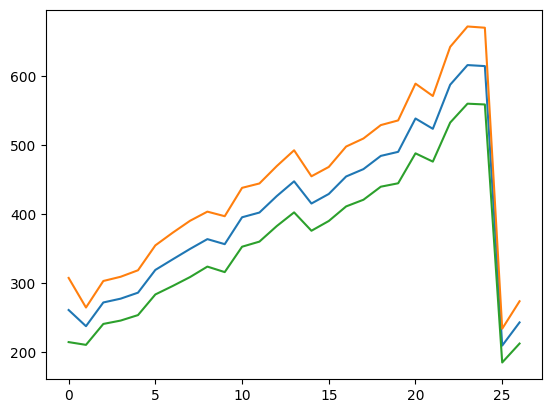

In [ ]:
plt.plot(averages)
plt.plot(np.asarray(averages)+np.asarray(stds))
plt.plot(np.asarray(averages)-np.asarray(stds))

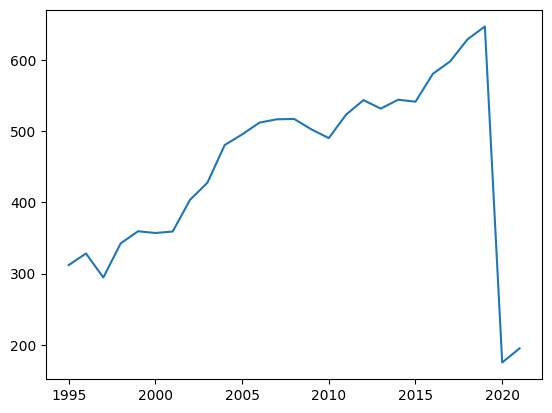

In [ ]:

countries_ = []
for year in range(1995,2022):
    countries_.append(list(tour_arrivals.loc[(slice(None), year), 'tour_per_1000'].dropna().index.get_level_values('country').unique()))


overlap = set(countries_[0])
for lst in countries_[1:]:
    overlap = overlap.intersection(lst)

overlapped_ = list(overlap)
x = tour_arrivals.loc[(overlapped_, slice(None)), 'tour_per_1000'].groupby('year').median()
plt.figure()
plt.plot(x)

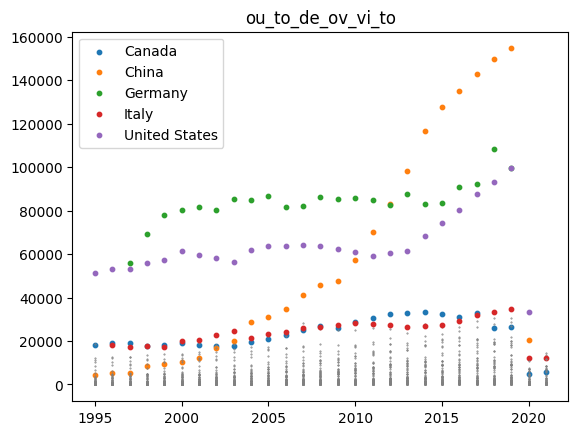

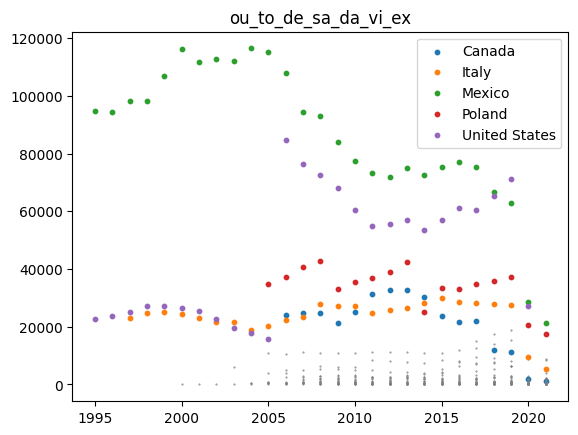

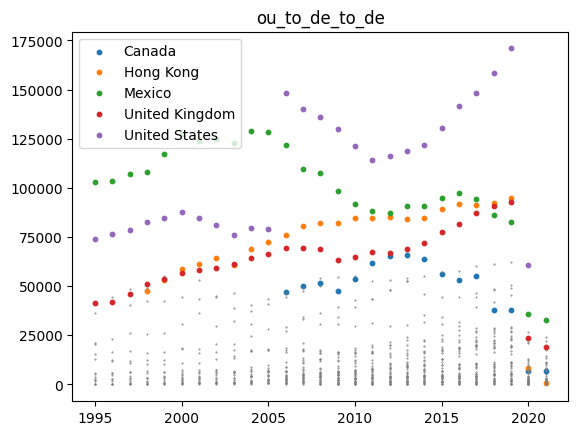

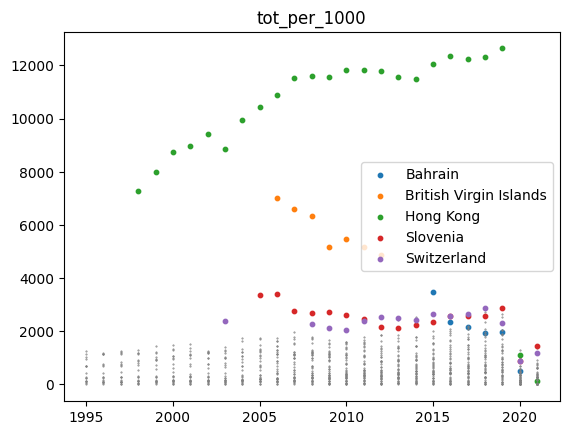

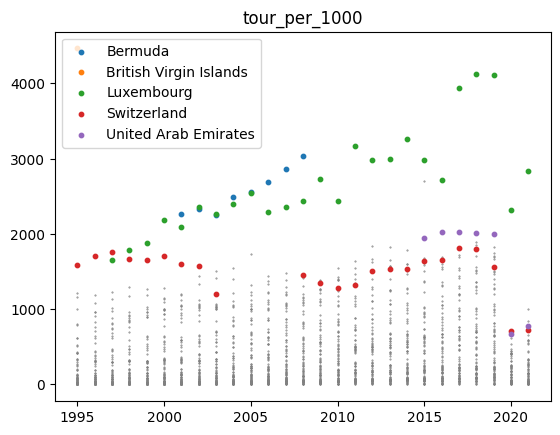

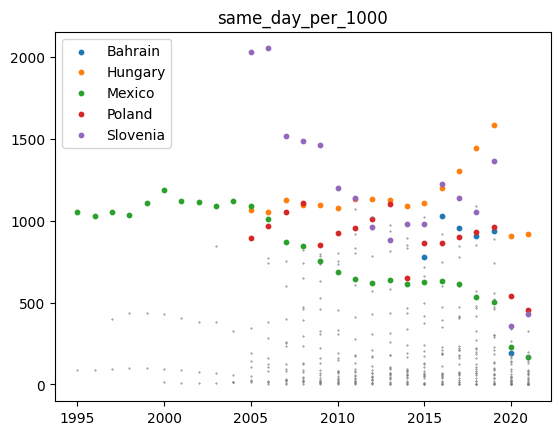

In [ ]:
dataframes = [tour_arrivals, outbound, domestic_accommodation, domestic_tourism, employment, inbound_accommodation, inbound_exp, purpose, regions, transport_mode, oubound_exp, tourism_ind, population]
df_pl =dataframes[1]
#for df in dataframes[:2]:
for col in df_pl.columns:
    x = df_pl[col].groupby('year').mean()
    plt.figure()
    #plt.plot(x, label=col)
    plt.title(col)
    top_countries = df_pl[col].groupby('country').median().nlargest(5).index

    for country in  df_pl[col].index.get_level_values('country').unique():
        x =  df_pl.loc[(country), col]

        if country in top_countries:
            plt.scatter(x.index,x, label = country,s = 10)
        else:
            plt.scatter(x.index,x, color = 'grey', s = 0.2)
    
    plt.legend()